In [ ]:
# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Internal import (this repo must be installed as package)
from market_regime.labeling import make_regime_labels

# Global variables
REPO_DIR: Path = Path("..").resolve()
assert REPO_DIR.name == "market-regime-classification", "`REPO_DIR` points to incorrect folder."
RAW_DATA_PATH: Path = REPO_DIR / "data/raw"

In [3]:
# Load data
df = pd.read_csv(RAW_DATA_PATH / "daily_prices.csv")
df["trading_date"] = pd.to_datetime(df["trading_date"], format="%Y-%m-%d")
df["delivery_date"] = pd.to_datetime(df["delivery_date"], format="%Y-%m-%d")
df = df.set_index("trading_date").sort_index()

# Calculate log returns
df[["open_t", "close_t"]] = df[["open", "close"]].copy()
df["close_t-1"] = df.groupby("delivery_date")["close_t"].shift(1).fillna(df["open_t"])
df["log_return_t"] = np.log(df["close_t"] / df["close_t-1"])

# Calculate standarized log returns (sharpe ratio) for window_len days into future
for window_len in [5, 10, 20]:
    df[f"log_return_t-{window_len-1}:t"] = df["log_return_t"].rolling(window=window_len, min_periods=window_len, center=False).sum()
    df[f"log_return_t+1:t+{window_len}"] = df[f"log_return_t-{window_len-1}:t"].shift(-window_len)
    df[f"volatility_t-{window_len-1}:t"] = df["log_return_t"].rolling(window=window_len, min_periods=window_len, center=False).std() * np.sqrt(window_len)
    df[f"volatility_t+1:t+{window_len}"] = df[f"volatility_t-{window_len-1}:t"].shift(-window_len)

    df[f"sharpe_ratio_{window_len}"] = df[f"log_return_t+1:t+{window_len}"] / df[f"volatility_t+1:t+{window_len}"]

In [18]:
df

,delivery_date,open,close,open_t,close_t,close_t-1,log_return_t,log_return_t-4:t,log_return_t+1:t+5,volatility_t-4:t,...,log_return_t+1:t+10,volatility_t-9:t,volatility_t+1:t+10,sharpe_ratio_10,log_return_t-19:t,log_return_t+1:t+20,volatility_t-19:t,volatility_t+1:t+20,sharpe_ratio_20,target
trading_date,,,,,,,,,,,,,,,,,,,,,
2015-11-30,2016-01-01,17.85,18.150,17.85,18.150,17.850,0.016667,NaN,-0.072837,NaN,...,-0.132351,NaN,0.035908,-3.685896,NaN,-0.197309,NaN,0.099157,-1.989873,-1.0
2015-12-01,2016-01-01,18.05,18.100,18.05,18.100,18.150,-0.002759,NaN,-0.074533,NaN,...,-0.120203,NaN,0.041470,-2.898555,NaN,-0.202961,NaN,0.098891,-2.052372,-1.0
2015-12-02,2016-01-01,18.15,17.675,18.15,17.675,18.100,-0.023761,NaN,-0.065765,NaN,...,-0.124880,NaN,0.043170,-2.892744,NaN,-0.192806,NaN,0.097936,-1.968687,-1.0
2015-12-03,2016-01-01,17.64,17.375,17.64,17.375,17.675,-0.017119,NaN,-0.052885,NaN,...,-0.101372,NaN,0.046630,-2.173936,NaN,-0.162082,NaN,0.100259,-1.616635,-1.0
2015-12-04,2016-01-01,17.35,17.450,17.35,17.450,17.375,0.004307,-0.022664,-0.074328,0.036381,...,-0.126922,NaN,0.044801,-2.833047,NaN,-0.133163,NaN,0.107906,-1.234068,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,2025-03-01,47.60,45.945,47.60,45.945,47.470,-0.032653,-0.102123,NaN,0.103583,...,NaN,0.142843,NaN,NaN,-0.079870,NaN,0.181486,NaN,NaN,NaN
2025-02-24,2025-03-01,46.52,47.345,46.52,47.345,45.945,0.030016,-0.008204,NaN,0.096652,...,NaN,0.138648,NaN,NaN,-0.012079,NaN,0.180863,NaN,NaN,NaN
2025-02-25,2025-03-01,47.00,43.990,47.00,43.990,47.345,-0.073499,-0.126059,NaN,0.098382,...,NaN,0.148280,NaN,NaN,-0.096679,NaN,0.194381,NaN,NaN,NaN


<Axes: xlabel='trading_date'>

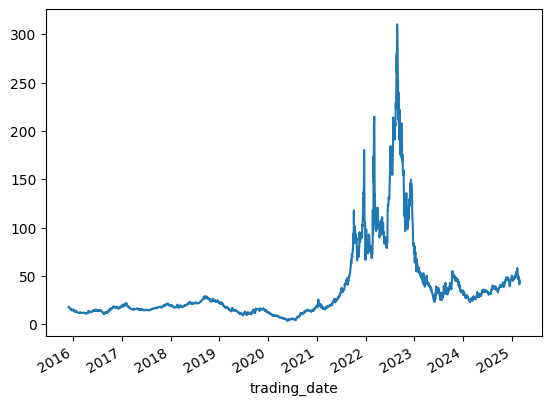

In [4]:
df["close_t"].plot()

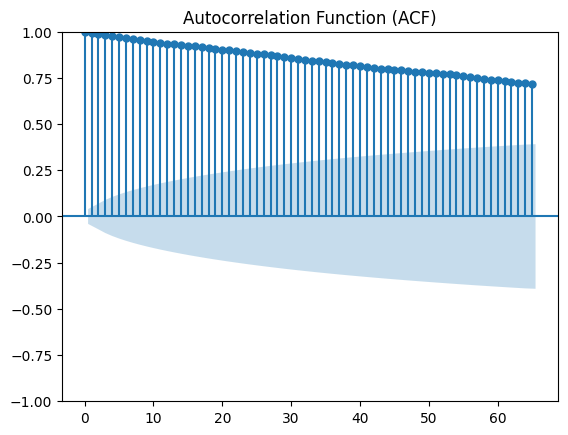

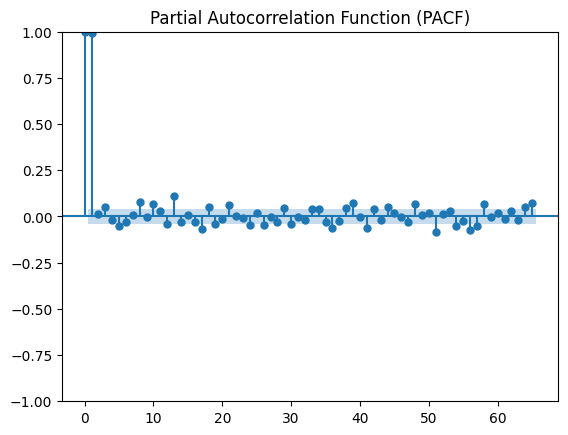

In [ ]:
# Plot ACF
sm.graphics.tsa.plot_acf(df["close_t"], lags=65)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df["close_t"], lags=65)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
# miary statystyczne
# - mutual information
# - forecastability

<Axes: xlabel='trading_date'>

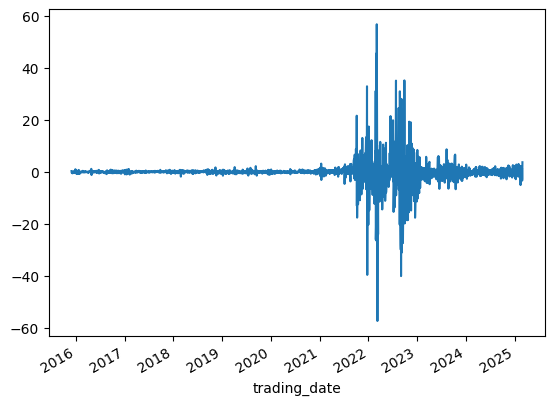

In [11]:
(df["close_t"] - df["close_t-1"]).plot()

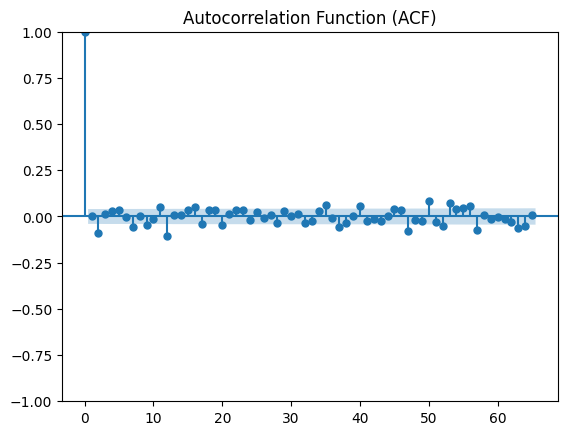

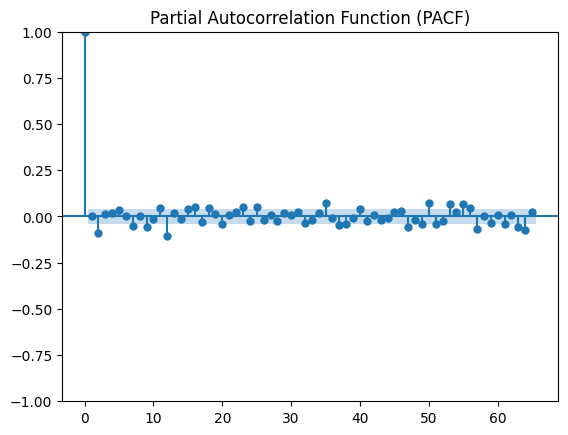

In [23]:
# Plot ACF
sm.graphics.tsa.plot_acf(df["close_t"] - df["close_t-1"], lags=65)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df["close_t"] - df["close_t-1"], lags=65)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

<Axes: xlabel='trading_date'>

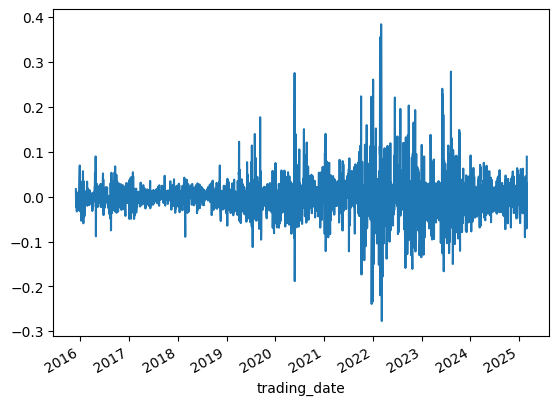

In [12]:
((df["close_t"] - df["close_t-1"]) / df["close_t-1"]).plot()

<Axes: ylabel='Count'>

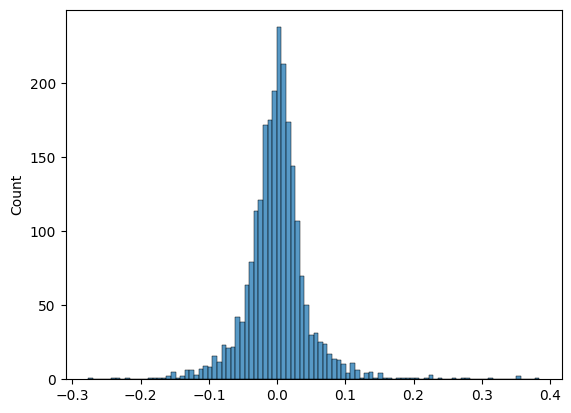

In [14]:
sns.histplot((df["close_t"] - df["close_t-1"]) / df["close_t-1"])

In [15]:
((df["close_t"] - df["close_t-1"]) / df["close_t-1"]).describe()

count    2367.000000
mean        0.000145
std         0.047576
min        -0.276887
25%        -0.021174
50%         0.000000
75%         0.019775
max         0.384034
dtype: float64

<Axes: xlabel='trading_date'>

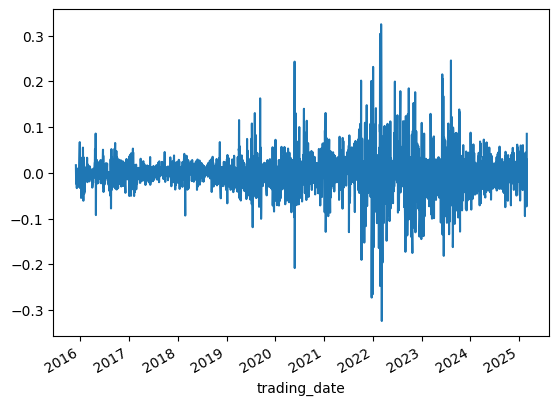

In [ ]:
df["log_return_t"].plot()

<Axes: xlabel='log_return_t', ylabel='Count'>

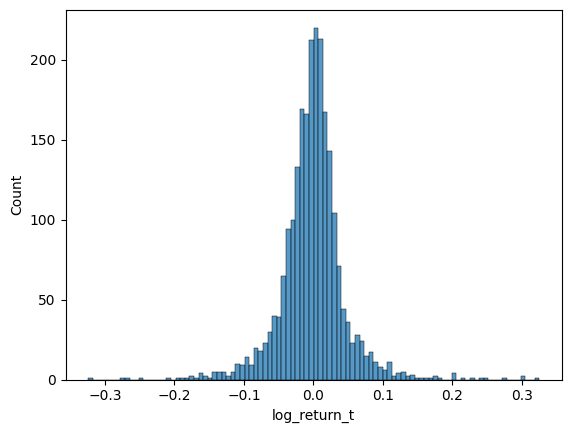

In [16]:
sns.histplot(df["log_return_t"])

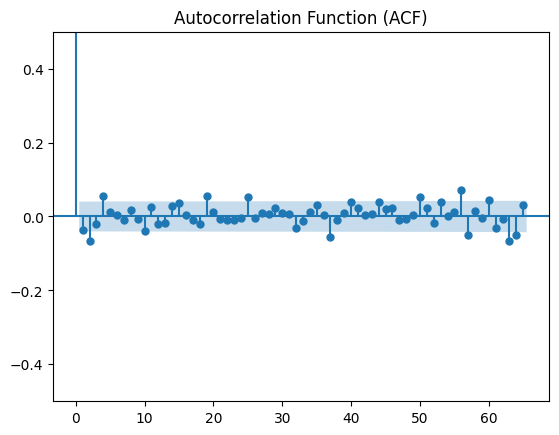

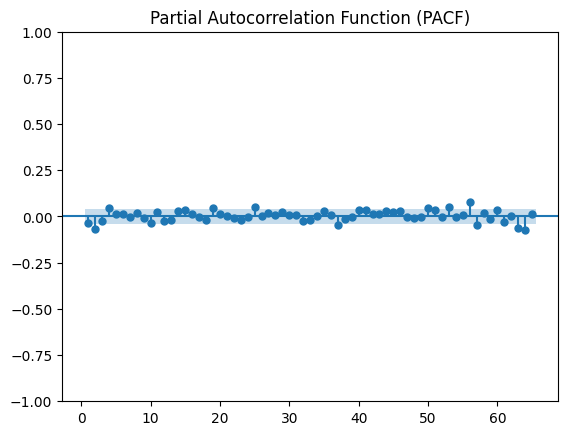

: 

In [ ]:
# Plot ACF
sm.graphics.tsa.plot_acf(df["log_return_t"], lags=65)
# plt.ylim(-0.5, .5)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
sm.graphics.tsa.plot_pacf(df["log_return_t"], lags=65, zero=False)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [17]:
df["log_return_t"].describe()

count    2367.000000
mean       -0.000966
std         0.047043
min        -0.324190
25%        -0.021402
50%         0.000000
75%         0.019582
max         0.325002
Name: log_return_t, dtype: float64

,sharpe_ratio_5,sharpe_ratio_10,sharpe_ratio_20
count,2362.000000,2357.000000,2347.000000
mean,-0.049927,-0.078564,-0.075581
std,1.370718,1.215419,1.199031
min,-9.899373,-4.915901,-3.448336
25%,-0.847935,-0.838396,-0.921076
50%,-0.085891,-0.087319,-0.064875
75%,0.691493,0.676419,0.705721
max,9.799656,4.396857,4.643171


<Axes: ylabel='Count'>

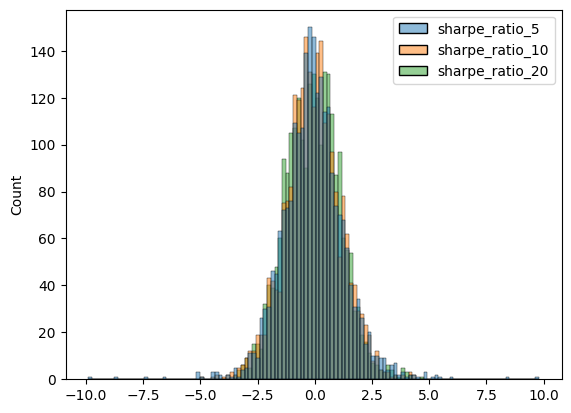

In [5]:
display(df.filter(like="sharpe_ratio").describe())
sns.histplot(df.filter(like="sharpe_ratio"))

<Axes: xlabel='sharpe_ratio_20', ylabel='Count'>

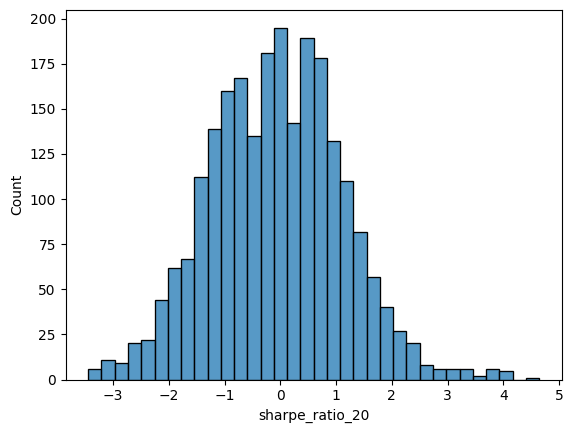

In [6]:
# 20 dni w przod wydaje sie sensownym wyborem: jest to okolo miesiac kalendarzowy 
sns.histplot(df["sharpe_ratio_20"])     # type:ignore

target
-1.0    0.364425
 0.0    0.332321
 1.0    0.303254
Name: proportion, dtype: float64

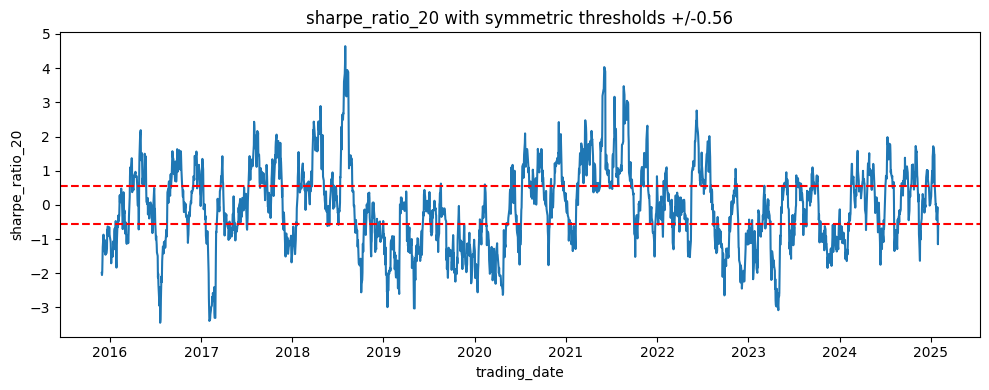

In [7]:
# Calculate target
target, k = make_regime_labels(
    df, window_len=20, delivery_date_cutoff=pd.Timestamp("2025-01-01")
)
df = df.drop(columns="target", errors="ignore")
df = df.join(target)

display(df["target"].value_counts(normalize=True).sort_index())

col = "sharpe_ratio_20"
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x=df.index, y=df[col], ax=ax)
ax.axhline(y=k, color="red", linestyle="--")
ax.axhline(y=-k, color="red", linestyle="--")
ax.set_xlabel("trading_date")
ax.set_ylabel(col)
ax.set_title(f"{col} with symmetric thresholds +/-{k}")
plt.tight_layout()
plt.show()